# Proyecto Final - PDS 2023-1
### Aplicación de Filtros FIR a Audios de Animales por Método de Enventanado y Método de Muestreo en Frecuencia
`Antonio José Aristizábal García CC: 1152468786`
***

### Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import*
import scipy.signal as signal
from scipy.io.wavfile import read # libreria para lectura de archivos de audio
from IPython.display import Audio # para escuchar la senal
from scipy .io. wavfile import write
from scipy . signal import resample
import scipy.signal as sp

***
## 1. Filtros FIR por Método de Enventanado

`1.1. Escriba un programa que grafique la señal de audio 'Animals.wav'. Normalice la señal en amplitud, elimine su nivel DC y cree su vector de tiempo según la frecuencia de muestreo. Cargue el audio para escucharlo. ¿Qué animales logra distinguir?`

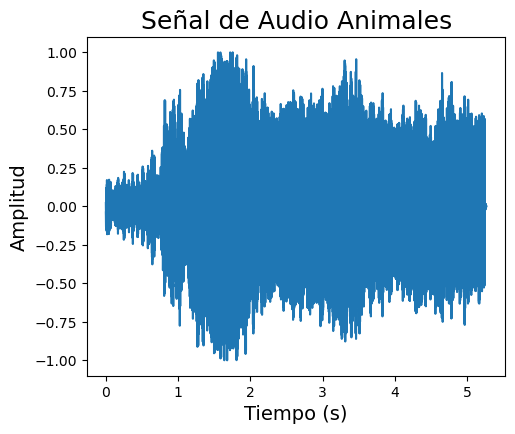

In [2]:
file_audio=('Animals.wav') # Ruta del archivo con la senal
fs, animals_signal=read(file_audio) # Cargar el archivo
animals_signal = animals_signal[:, 0] # Necesario cuando el audio utiliza dos canales
animals_signal=(animals_signal - np.mean(animals_signal))/float(max(abs(animals_signal))) # Escala la amplitud de la senal y elimina DC
t=np.arange(0, (float(len(animals_signal))/fs), 1.0/fs) # Vector de tiempo

plt.figure(figsize=(5.4, 4.4))
plt.plot(t,animals_signal) # Dibujar la grafica
plt.xlabel('Tiempo (s)', fontsize=14) # Etiqueta eje X
plt.ylabel('Amplitud', fontsize=14) # Etiqueta eje Y
plt.title("Señal de Audio Animales", fontsize=18)
plt.show() # Mostrar la grafica
Audio(animals_signal, rate=fs) # para escuchar la señal

Al reproducir el audio se logra escuchar el aullido de un lobo y el cantar de un pájaro, sin embargo, es difícil reconocer si hay más animales o no.

***
`1.2. Escriba un programa que permita graficar el espectro de la señal de audio. Límite la señal en el eje x entre -5000 y 5000.`

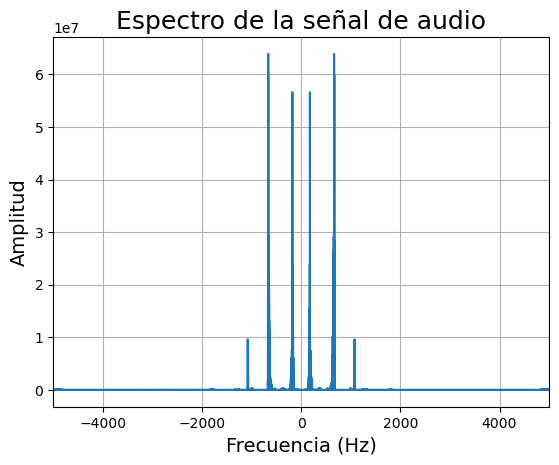

In [3]:
# FFT
ANIMALS_SIGNAL = np.fft.fft(animals_signal)
animals_signal_freq = np.fft.fftfreq(len(animals_signal))*fs

plt.figure()
plt.plot(animals_signal_freq, abs(ANIMALS_SIGNAL)**2)
plt.title('Espectro de la señal de audio', fontsize=18)
plt.xlabel("Frecuencia (Hz)", fontsize=14)
plt.ylabel("Amplitud", fontsize=14)
plt.xlim([-5000, 5000])
# plt.ylim([0, 0.025e7])
plt.grid()

plt.show()

Se observan diversos picos de amplitud para diferentes frecuencias, por lo que es posible separarlos y obtener cada uno de los sonidos de los animales mediante el uso de filtros.

***
`1.3. Implemente un filtro FIR pasa bajas mediante el método del enventanado con las siguientes características: frecuencia de muestreo fs = fs_audio, frecuencia de corte fc = 300Hz, ancho de banda de transición fm = 200Hz, ripple de 0.3%. Seleccione la respuesta del filtro y la ventana más adecuada. Explique paso a paso y grafique la respuesta en frecuencia del filtro.`

Se especifican las características del filtro pasa bajas:

In [4]:
# Características especificadas del filtro
Fs = fs
print("Frecuencia de Muestreo del audio: ", Fs)
Fc_pb = 0.3e3
fm_pb = 200

Frecuencia de Muestreo del audio:  48000


In [5]:
# Cálculo del Ripple en dB
ripple_dB = 20 * np.log10(0.003)
print("El ripple en dB es:", ripple_dB)

El ripple en dB es: -50.45757490560675


Al obtener un ripple en dB de -50.46 la ventana ideal es la de tipo Hamming. Se calcula entonces el orden del filtro:

In [6]:
M = 4*Fs/fm_pb
if M % 2 == 0:
    M += 1
print('Orden del filtro M (Aproximado al impar superior):', int(M))  

Orden del filtro M (Aproximado al impar superior): 961


Luego, es necesario normalizar la frecuencia de corte en radianes, seleccionar la respuesta del filtro para un pasabajas y la función de la ventana Hamming:

In [7]:
wc_pb = 2*np.pi*Fc_pb/Fs # frecuencia de corte normalizada en radianes
n = np.arange(-M//2+1, M//2+1) # Vector de muestras

hi_pb = wc_pb/np.pi * np.sinc(wc_pb*n/np.pi) # Respuesta del filtro ideal pasa-bajos
hi_pb[M==0] = wc_pb/np.pi

win = 0.54-0.46*np.cos(2*np.pi*np.arange(len(n))/(M-1)) # Ventana de Hamming
h_n_pb = hi_pb*win # Multiplico la respuesta ideal por la ventana
w, h = sp.freqz(h_n_pb, 1, whole=True, worN=2048) # Respuesta en frecuencia del filtro enventanado

Finalmente, se obtiene la gráfica de la respuesta en frecuencia del filtro pasa bajas:

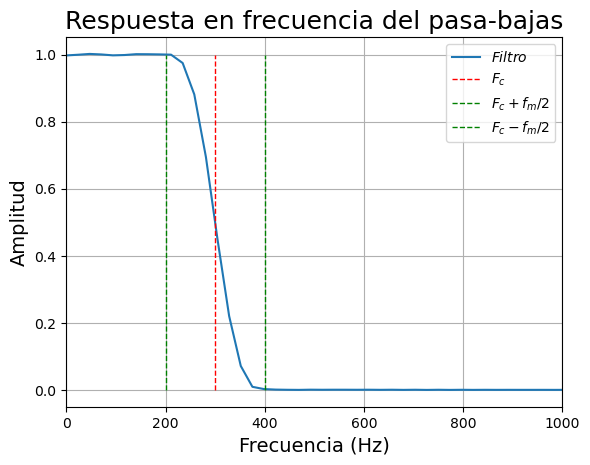

In [8]:
# Grafica para la respuesta en frecuencia del pasa bajas
plt.figure()
plt.title('Respuesta en frecuencia del pasa-bajas', fontsize=18)
plt.plot((w-np.pi)*Fs/(2*np.pi),np.abs(np.fft.fftshift(h)), label='$Filtro$')
plt.vlines(Fc_pb, 0, 1, color='r', lw=1, linestyle='--', label='$F_c$')
plt.vlines(Fc_pb+fm_pb/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_c+f_m/2$')
plt.vlines(Fc_pb-fm_pb/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_c-f_m/2$')
plt.xlabel('Frecuencia (Hz)', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.xlim([0, 1000])
plt.legend()
plt.grid()
plt.show()

Se obtiene que el filtro pasa bajas corta correctamente en 300 Hz y tiene un ancho de banda de transición de aproximadamente 200Hz.

***
`1.4. Repita el procedimiento anterior, pero ahora implementando un filtro pasa-bandas con las siguientes características: frecuencia de muestreo Fs = fs, frecuencia de corte 1 fc1 = 1.5kHz, frecuencia de corte fc2 = 2kHz, ancho de banda de transición fm = 100Hz, ripple de 0.7%.`

Se especifican las características del filtro pasa bandas:

In [9]:
# Características especificadas del filtro pasa bandas
Fs = fs
print("Frecuencia de Muestreo del audio: ", Fs)
Fc1_bp = 1.5e3
Fc2_bp = 2e3
fm_bp = 100

Frecuencia de Muestreo del audio:  48000


In [10]:
# Cálculo del Ripple en dB
ripple_dB = 20 * np.log10(0.007)
print("El ripple en dB es:", ripple_dB)

El ripple en dB es: -43.09803919971486


Al obtener un ripple en dB de -43.1 la ventana ideal es la de tipo Hann. Se calcula entonces el orden del filtro:

In [11]:
M = 4*Fs/fm_bp
if M % 2 == 0:
    M += 1
print('Orden del filtro M (Aproximado al impar superior):', int(M))  

Orden del filtro M (Aproximado al impar superior): 1921


Luego, es necesario normalizar la frecuencia de corte en radianes, seleccionar la respuesta del filtro para un pasa bandas y la función de la ventana Hann:

In [12]:
wc1_bp = 2*np.pi*Fc1_bp/Fs # frecuencia de corte 1 normalizada en radianes
wc2_bp = 2*np.pi*Fc2_bp/Fs # frecuencia de corte 2 normalizada en radianes
n = np.arange(-M//2+1, M//2+1) # Vector de muestras

hi_bp = (wc2_bp/np.pi) * np.sinc(wc2_bp*n/np.pi) - (wc1_bp/np.pi) * np.sinc(wc1_bp*n/np.pi) # Respuesta del filtro ideal pasa-bandas
hi_bp[M==0] = (wc2_bp-wc1_bp)/np.pi 

win_bp = 0.5*(1-np.cos(2*np.pi*np.arange(len(n))/(M-1)))# Ventana de Hann
h_n_bp = hi_bp*win_bp # Multiplico la respuesta ideal por la ventana
w, h = sp.freqz(h_n_bp, 1, whole=True, worN=2048) # Respuesta en frecuencia del filtro enventanado

Finalmente, se obtiene la gráfica de la respuesta en frecuencia del filtro pasa bandas:

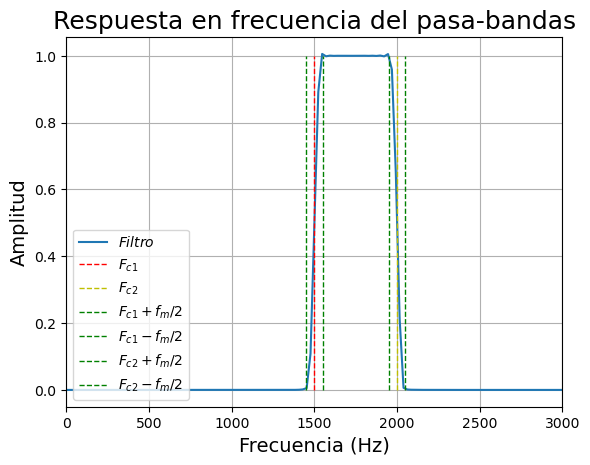

In [13]:
# Grafica de la respuesta en frecuencia del pasa bandas
plt.figure()
plt.title('Respuesta en frecuencia del pasa-bandas', fontsize=18)
plt.plot((w-np.pi)*Fs/(2*np.pi),np.abs(np.fft.fftshift(h)), label='$Filtro$')
plt.vlines(Fc1_bp, 0, 1, color='r', lw=1, linestyle='--', label='$F_{c1}$')
plt.vlines(Fc2_bp, 0, 1, color='y', lw=1, linestyle='--', label='$F_{c2}$')
plt.vlines(Fc1_bp+fm_bp/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_{c1}+f_m/2$')
plt.vlines(Fc1_bp-fm_bp/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_{c1}-f_m/2$')
plt.vlines(Fc2_bp+fm_bp/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_{c2}+f_m/2$')
plt.vlines(Fc2_bp-fm_bp/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_{c2}-f_m/2$')
plt.xlabel('Frecuencia (Hz)', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.xlim([0, 3000])
plt.legend(loc='lower left')
plt.grid()
plt.show()

Se obtiene que el filtro pasa bandas corta correctamente en 1500 Hz y 2000 Hz y tiene un ancho de banda de transición de aproximadamente 100Hz.

***
## 2. Filtros FIR por Método de Muestreo en Frecuencia

`2.1. Implemente un filtro FIR pasa altas mediante el método de muestreo en frecuencia. Utilice como frecuencia de muestreo la misma frecuencia obtenida en el audio, frecuencia de corte 4.5kHz y seleccione un valor de muestras N que permita obtener un filtro adecuado. Explique paso a paso y grafique la respuesta en frecuencia del filtro.`

Inicialmente se especifican los valores para fs y N. También se selecciona el kmax según el valor de N, el alpha y el paso del muestreo.

In [14]:
# Características
Fs = fs
N = 300
if N % 2 == 0:
    kmax = N//2 - 1 # Si N par
else:
    kmax = (N-1)//2 # Si N impar
alpha = (N-1)/2 # Alpha por fórmula
paso = Fs/N # Tamaño de paso para muestrear

Se define la función $\left | H(k) \right |$ que permitirá posteriormente calcular $h(n)$:

In [15]:
# Fórmula para H(k) filtro pasa altas
H_k = []
for k in range(kmax+1):
    if paso*k >= 0 and paso*k <= 4.5e3:  # Entre 0 y 4.5kHz es cero
        H_k.append(0)
    else:                                # A partir de 4.5kHz es uno
        H_k.append(1)

Se realiza el cálculo de $h(n)$ utilizando la fórmula de sumatoria conocida:

In [16]:
# Cálculo de h(n)
h_n_pa = []
for n in range(N):
    suma = 0
    for k in np.arange(1, kmax+1):
        suma += (1/N)*2*H_k[k]*np.cos(2*np.pi*k*(n-alpha)/N)
    suma += (1/N)*H_k[0]
    h_n_pa.append(suma)

Se grafica la respuesta en frecuencia del filtro pasa altas obtenido:

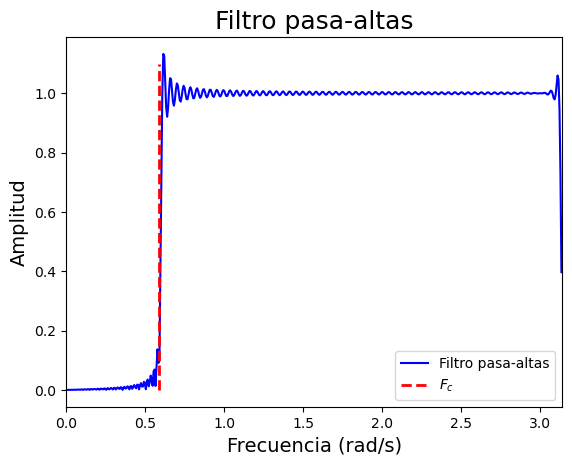

In [17]:
# Gráfica de la respuesta en frecuencia del filtro pasa altas
w, h = sp.freqz(h_n_pa, 1, whole=True, worN=1024)
plt.figure()
plt.title('Filtro pasa-altas', fontsize=18)
plt.plot(w-np.pi, np.abs(np.fft.fftshift(h)), 'b', label='Filtro pasa-altas')
plt.vlines(2*np.pi*4.5e3/Fs, 0, 1.1, color='r', lw=2, linestyle='--', label='$F_c$')
plt.xlabel('Frecuencia (rad/s)', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.xlim([0, np.pi])
plt.legend(loc='best')
plt.show()

Se obtiene que el filtro pasa altas corta correctamente en 4.5 kHz (0.59 en radianes) y se realiza un muestreo correcto al utilizar un N de 300, aunque se presenta el fénomeno de Gibbs, por lo que para reducirlo es necesario utilizar un valor de N más alto, lo cual costará más recursos computacionales.

***
`2.2. Repita el procedimiento anterior, pero ahora implemente un filtro pasa bandas con frecuencias de corte entre 300Hz y 1.6kHz. Explique paso a paso y grafique la respuesta en frecuencia del filtro.`

Inicialmente se especifican los valores para fs y N. También se selecciona el kmax según el valor de N, el alpha y el paso del muestreo.

In [18]:
# Características
Fs = fs
N = 1000
if N % 2 == 0:
    kmax = N//2 - 1 # Si N par
else:
    kmax = (N-1)//2 # Si N impar
alpha = (N-1)/2 # Alpha por fórmula
paso = Fs/N # Tamaño de paso para muestrear

Se define la función $\left | H(k) \right |$ que permitirá posteriormente calcular $h(n)$:

In [19]:
# Fórmula para H(k) filtro pasa bandas
H_k = []
for k in range(kmax+1):
    if (0.3e3 <= paso*k <= 1.6e3):
        H_k.append(1)
    else:
        H_k.append(0)
# H_k

Se realiza el cálculo de $h(n)$ utilizando la fórmula de sumatoria conocida:

In [20]:
# Cálculo de h(n)
h_n_bp2 = []
for n in range(N):
    suma = 0
    for k in np.arange(1, kmax+1):
        suma += (1/N)*2*H_k[k]*np.cos(2*np.pi*k*(n-alpha)/N)
    suma += (1/N)*H_k[0]
    h_n_bp2.append(suma)

Se grafica la respuesta en frecuencia del filtro pasa altas obtenido. Se realiza un zoom entre 0 y $\frac{\pi }{3}$ para facilitar la visualización del filtro:

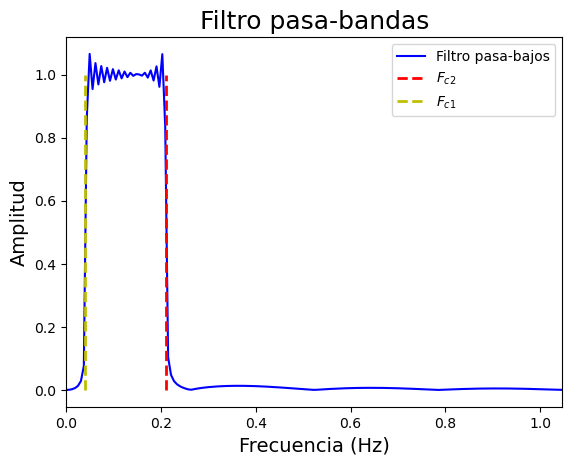

In [21]:
# Gráfica de la respuesta en frecuencia del filtro pasa bandas
w, h = sp.freqz(h_n_bp2, 1, whole=True, worN=1024)
plt.figure()
plt.title('Filtro pasa-bandas', fontsize=18)
plt.plot(w-np.pi, np.abs(np.fft.fftshift(h)), 'b', label='Filtro pasa-bajos')
plt.vlines(2*np.pi*1.6e3/Fs, 0, 1, color='r', lw=2, linestyle='--', label='$F_{c2}$')
plt.vlines(2*np.pi*0.3e3/Fs, 0, 1, color='y', lw=2, linestyle='--', label='$F_{c1}$')
plt.xlabel('Frecuencia (Hz)', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.xlim([0, np.pi/3])
plt.legend(loc='best')
plt.show()

Se obtiene que el filtro pasa bandas corta correctamente en 300 Hz (0.039 en radianes) y 1.6kHz (0.21 en radianes) y se realiza un muestreo correcto al utilizar un N de 1000, pero nuevamente se presenta Gibbs.

***
## 3. Filtrado de Sonidos Animales con filtros FIR

`3.1.1. Aplique el filtro pasa bajas obtenido en el literal 1 mediante el método de enventanado al audio Animals.wav`

In [22]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
y = np.convolve(h_n_pb, animals_signal, mode="same")
Y = np.fft.fft(y)
Y_freq = np.fft.fftfreq(len(Y))*fs

***
`3.1.2. Reproduzca el audio obtenido tras filtrar y grafique su espectro limitando el eje entre -300 y 300. ¿Qué animal escucha? Explique.`

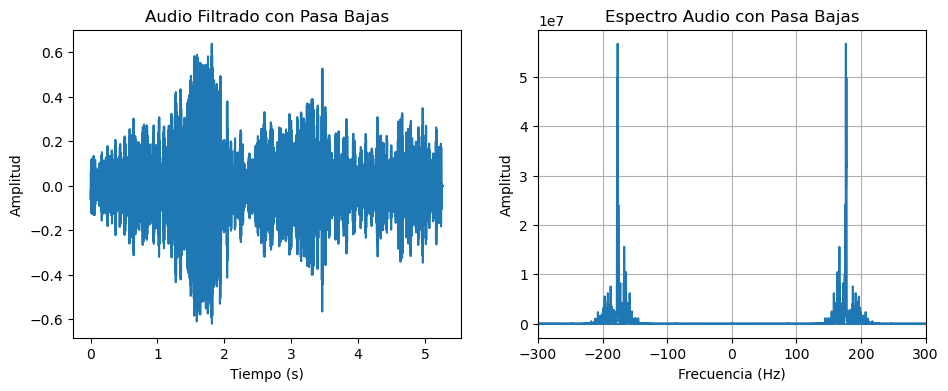

In [23]:
# Gráficas de la señal de audio filtrada con pasa bajas y su espectro
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(t, y)
plt.title("Audio Filtrado con Pasa Bajas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid

plt.subplot(122)
plt.plot(Y_freq, abs(Y)**2)
plt.title("Espectro Audio con Pasa Bajas")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.xlim([-300, 300])
plt.grid()

plt.show()

Audio(y, rate=fs) # Reproducción del audio filtrado 

Se logra escuchar lo que parece ser una ballena y se suprimen los otros animales. Este sonido tiene una frecuencia muy baja como se puede observar en su espectro, ya que tiene valores entre 150 y 250 Hz aproximadamente. Por esto mismo es que se optó por filtrar con un pasa bajas.

***
***
`3.2.1. Repita el literal 3.1.1. para el filtro pasa bandas obtenido mediante el método de enventanado.`

In [24]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
y = np.convolve(h_n_bp, animals_signal, mode="same")
Y = np.fft.fft(y)
Y_freq = np.fft.fftfreq(len(Y))*fs

***
`3.2.2. Repita el literal 3.1.2. graficando el espectro entre -2500 y 2500.`

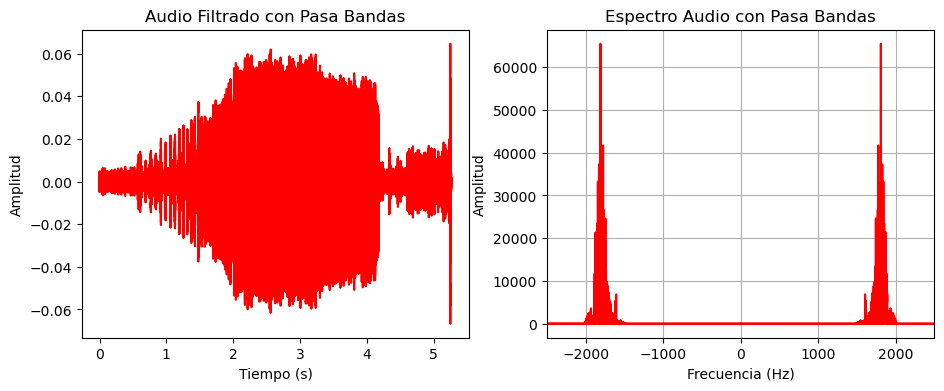

In [25]:
# Gráficas de la señal de audio filtrada con pasa bandas y su espectro
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(t, y, 'r')
plt.title("Audio Filtrado con Pasa Bandas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid

plt.subplot(122)
plt.plot(Y_freq, abs(Y)**2, 'r')
plt.title("Espectro Audio con Pasa Bandas")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.xlim([-2500, 2500])
plt.grid()

plt.show()

Audio(y, rate=fs) # Reproducción del audio filtrado 

Se logra escuchar lo que parece ser una foca leopardo y se suprimen los otros animales. Como se puede observar en el espectro obtenido, la frecuencia del sonido emitido por este animal está entre 1500 y 2000 Hz aproximadamente. Por esto mismo se utilizó un filtro pasa bandas, de tal forma que solo quedara este rango de frecuencias.

***
***
`3.3.1. Aplique el filtro pasa altas obtenido en el literal 2 mediante el método de muestreo en frecuencia al audio Animals.wav`

In [26]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
y = np.convolve(h_n_pa, animals_signal, mode="same")
Y = np.fft.fft(y)
Y_freq = np.fft.fftfreq(len(Y))*fs

***
`3.3.2. Reproduzca el audio obtenido tras filtrar y grafique su espectro limitando el eje entre -8000 y 8000. ¿Qué animal escucha? Explique.`

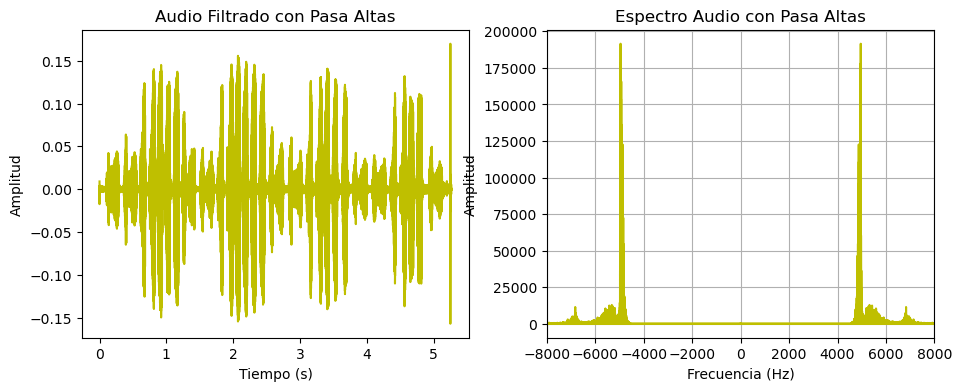

In [27]:
# Gráficas de la señal de audio filtrada pasa altas y su espectro
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(t, y, 'y')
plt.title("Audio Filtrado con Pasa Altas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid

plt.subplot(122)
plt.plot(Y_freq, abs(Y)**2, 'y')
plt.title("Espectro Audio con Pasa Altas")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.xlim([-8000, 8000])
plt.grid()

plt.show()

Audio(y, rate=fs) # Reproducción del audio filtrado 

Se logra escuchar lo que parece ser el canto de un ave Herrerillo Común (Cyanistes_caeruleus). Como se puede observar en el espectro obtenido, la frecuencia del sonido emitido por este animal está entre 4500 y 7500 Hz aproximadamente. Por esto mismo se utilizó un filtro pasa altas, ya que entre los animales del audio es el que mayor frecuencia presenta.

***
***
`3.4.1. Repita el literal 3.3.1. para el filtro pasa bandas obtenido mediante el método de muestreo en frecuencia.`

In [28]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
y = np.convolve(h_n_bp2, animals_signal, mode="same")
Y = np.fft.fft(y)
Y_freq = np.fft.fftfreq(len(Y))*fs

***
`3.4.2. Repita el literal 3.3.2. graficando el espectro entre -1600 y 1600.`

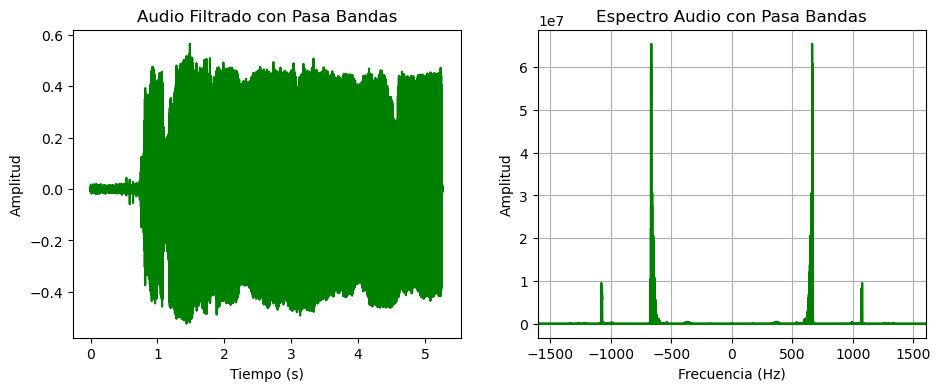

In [29]:
# Gráficas de la señal de audio filtrada pasa bandas y su espectro
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(t, y, 'g')
plt.title("Audio Filtrado con Pasa Bandas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid

plt.subplot(122)
plt.plot(Y_freq, abs(Y)**2, 'g')
plt.title("Espectro Audio con Pasa Bandas")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.xlim([-1600, 1600])
plt.grid()

plt.show()

Audio(y, rate=fs) # Reproducción del audio filtrado 

Se logra escuchar el aullido de un lobo. Como se puede observar en el espectro obtenido, la frecuencia del sonido emitido por este animal está entre 300 y 1600 Hz aproximadamente. Debido a esto se optó por un filtro pasa bandas, ya que este permite filtrar el audio en el rango de frecuencias específico de este animal.

***
## 4. Conclusiones

>* La diferencia entre los dos métodos de diseño de filtros FIR utilizados es que el método de enventanado aplica una función de ventana a una respuesta al impulso ideal según ciertos criterios de diseño y el método de muestreo en frecuencia se centra en muestrear la respuesta deseada del filtro y después obtener la respuesta al impulso correspondiente mediante la transformada inversa de Fourier.
>* Los enventanados permiten reducir en gran parte el fenómeno de Gibbs, ya que permiten atenuar los bordes de la señal y por tanto reducir las discontinuidades, pero esto a costa de aumentar el roll off en la señal.
>* En el método de muestreo en frecuencia es necesario seleccionar un valor apropiado de N, ya que de no ser así es posible que los pasos de muestreo no sean suficientes para obtener el filtro deseado.
>* La aplicación de los filtros FIR en el audio animales combinados permite separar los diferentes sonidos de los animales que se encuentran en este, ya que cada uno de estos tiene una frecuencia diferente.